In [15]:
import numpy as np
from scipy.optimize import minimize

def compact_svd(a):
    u, s, vt = np.linalg.svd(a, False)
    mask = s > 1e-4
    return u[:, mask], np.diag(s[mask]), vt.T[:, mask]

np.random.seed(1)

# Define the objective function
def objective(params, X, d_in, d_hidden, d_out):
    n = X.shape[1]

    # Extract W1 and W2 from the flattened parameter array
    W1 = params[:d_hidden * d_in].reshape((d_hidden, d_in))
    W2 = params[d_hidden * d_in:].reshape((d_out, d_hidden))

    # Calculate terms of the objective
    term1 = np.linalg.norm(W2, 'fro')**2
    term2 = np.trace(W1.T @ W1 @ X @ X.T)

    return term1 + term2

# Define the constraint function
def constraint(params, X, Y, d_in, d_hidden, d_out):
    n = X.shape[1]

    # Extract W1 and W2 from the flattened parameter array
    W1 = params[:d_hidden * d_in].reshape((d_hidden, d_in))
    W2 = params[d_hidden * d_in:].reshape((d_out, d_hidden))

    # Constraint: W2 W1 X X^T - Y X^T = 0
    return (W2 @ W1 @ X @ X.T - Y @ X.T).flatten()

# Define the optimization function
def optimize_weights(X, Y, d_in, d_hidden, d_out):
    n = X.shape[1]

    # Initial guess for W1 and W2 (flattened)
    W1_init = np.random.rand(d_hidden, d_in)
    W2_init = np.random.rand(d_out, d_hidden)
    initial_params = np.hstack((W1_init.flatten(), W2_init.flatten()))

    # Constraints definition
    cons = {'type': 'eq', 'fun': constraint, 'args': (X, Y, d_in, d_hidden, d_out)}

    # Optimization
    result = minimize(
        fun=objective,
        x0=initial_params,
        args=(X, d_in, d_hidden, d_out),
        constraints=cons,
        method='SLSQP',
        options={'disp': True, 'ftol': 1e-9}
    )

    # Extract optimized W1 and W2
    optimized_params = result.x
    W1_opt = optimized_params[:d_hidden * d_in].reshape((d_hidden, d_in))
    W2_opt = optimized_params[d_hidden * d_in:].reshape((d_out, d_hidden))

    return W1_opt, W2_opt

# Example usage
if __name__ == "__main__":
    # Problem dimensions
    d_in = 4       # Input dimensionality
    d_hidden = 6   # Hidden dimensionality
    d_out = 5      # Output dimensionality
    n = 3          # Number of samples

    # Example input values
    X = np.random.rand(d_in, n)
    Y = np.random.rand(d_out, n)

    # Optimize W1 and W2
    W1_opt, W2_opt = optimize_weights(X, Y, d_in, d_hidden, d_out)

    # Check results
    print(W2_opt @ W1_opt @ X @ X.T - Y @ X.T)
    print(W2_opt @ W1_opt - Y @ X.T @ np.linalg.pinv(X @ X.T))
    print(np.linalg.norm(W1_opt @ X), np.linalg.norm(W2_opt))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.176269478082915
            Iterations: 83
            Function evaluations: 4639
            Gradient evaluations: 83
[[-3.80643295e-11 -1.50003343e-11 -2.40014675e-11 -4.06382705e-11]
 [ 1.74070758e-11  1.04305453e-11  1.64361302e-11  3.13505888e-11]
 [-2.52618204e-11 -8.28118130e-12 -1.16335275e-11 -1.85733651e-11]
 [-8.44024850e-12 -5.15715248e-12 -7.60325136e-12 -1.48367985e-11]
 [-5.66853231e-11 -2.62978528e-11 -4.19094759e-11 -7.48301421e-11]]
[[-0.15367274  0.58632824  0.56167433 -0.40421683]
 [-0.27955599  1.06662755  1.02177803 -0.73533693]
 [-0.10104874  0.38554486  0.36933348 -0.26579603]
 [-0.36957527  1.4100902   1.35079878 -0.97212134]
 [-0.37063321  1.41412669  1.35466554 -0.97490411]]
1.894301667677509 1.8941728194431269


In [31]:
a, b, c = compact_svd(Y)
j, k, l = compact_svd(X)
u, s, v = compact_svd(Y @ X.T @ np.linalg.pinv(X.T))
r1, s1, v1 = compact_svd(W1_opt @ X)
u2, s2, r2 = compact_svd(W2_opt)
print(np.round(X.T @ W1_opt.T @ W1_opt @ X - f @ f.T @ v @ s @ v.T @ f @ f.T, 4))
print(np.round(np.round(X.T @ W1_opt.T @ W1_opt @ X, 4) - np.round(v @ s @ v.T, 4), 6))

[[ 0.0002 -0.0001 -0.    ]
 [-0.0001  0.0001  0.    ]
 [-0.      0.      0.    ]]
[[ 0.0002 -0.0001  0.    ]
 [-0.0001  0.0001  0.    ]
 [ 0.      0.      0.    ]]


In [32]:
np.round(W2_opt.T @ W2_opt, 2) - np.round(W1_opt @ X @ X.T @ W1_opt.T, 2)

array([[0.  , 0.01, 0.  , 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [33]:
np.round(u @ np.sqrt(s), 2)

array([[-0.46,  0.54,  0.42],
       [-0.66, -0.2 , -0.01],
       [-0.39, -0.5 ,  0.5 ],
       [-0.8 , -0.38, -0.29],
       [-0.8 ,  0.48, -0.18]])

In [34]:
np.round(W2_opt @ r2, 2)

array([[ 0.46,  0.54,  0.42],
       [ 0.66, -0.2 , -0.01],
       [ 0.39, -0.5 ,  0.5 ],
       [ 0.8 , -0.38, -0.29],
       [ 0.8 ,  0.48, -0.18]])

In [35]:
rr = W1_opt @ X @ v @ np.linalg.pinv(np.sqrt(s))

In [38]:
np.round(rr.T @ rr, 3)

array([[ 1., -0.,  0.],
       [-0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [36]:
W1_opt @ X

array([[ 0.13971038,  0.46848951,  0.63170077],
       [ 0.73827765,  0.20530097, -0.00691776],
       [-0.22252373, -0.30175125,  0.06059193],
       [ 0.5386771 ,  0.78542224, -0.11271289],
       [ 0.57618493, -0.33253449,  0.61939923],
       [ 0.20738986,  0.37823452,  0.53551695]])

In [37]:
rr @ np.sqrt(s) @ v.T

array([[ 0.13971038,  0.46848951,  0.63170077],
       [ 0.73827765,  0.20530097, -0.00691776],
       [-0.22252373, -0.30175125,  0.06059193],
       [ 0.5386771 ,  0.78542224, -0.11271289],
       [ 0.57618493, -0.33253449,  0.61939923],
       [ 0.20738986,  0.37823452,  0.53551695]])

In [39]:
W1_opt @ j

array([[-0.53359364, -0.44310465, -1.46377617],
       [-0.41802958,  0.32529437,  2.48249346],
       [ 0.22197935, -0.44300642, -0.23849308],
       [-0.5774906 ,  1.0793727 ,  0.39502984],
       [-0.32233888, -1.22250118,  2.28664277],
       [-0.48148625, -0.38429476, -0.83543987]])

In [40]:
rr @ np.sqrt(s) @ v.T @ l @ np.linalg.pinv(k)

array([[-0.53359364, -0.44310465, -1.46377617],
       [-0.41802958,  0.32529437,  2.48249346],
       [ 0.22197935, -0.44300642, -0.23849308],
       [-0.5774906 ,  1.0793727 ,  0.39502984],
       [-0.32233888, -1.22250118,  2.28664277],
       [-0.48148625, -0.38429476, -0.83543987]])

In [53]:
z = W1_opt @ (np.identity(4) - j @ j.T)

In [55]:
np.round(W1_opt, 2)

array([[-0.28,  0.3 ,  2.47, -0.55],
       [-0.29,  4.05,  0.52, -0.85],
       [-0.74,  0.8 ,  1.17, -0.7 ],
       [ 1.  ,  1.09,  0.33, -0.5 ],
       [-1.05,  1.69, -1.08,  1.3 ],
       [-0.  , -0.43,  0.9 ,  0.32]])

In [59]:
np.round(rr @ np.sqrt(s) @ v.T @ np.linalg.pinv(X) + z, 2)

array([[-0.28,  0.3 ,  2.47, -0.55],
       [-0.29,  4.05,  0.52, -0.85],
       [-0.74,  0.8 ,  1.17, -0.7 ],
       [ 1.  ,  1.09,  0.33, -0.5 ],
       [-1.05,  1.69, -1.08,  1.3 ],
       [-0.  , -0.43,  0.9 ,  0.32]])

In [62]:
z = np.random.normal(0., 1., (1, 2))
np.linalg.pinv(z) @ z

array([[ 0.98377573, -0.12633703],
       [-0.12633703,  0.01622427]])

In [63]:
z

array([[ 2.46162831, -0.31612369]])

In [41]:
j @ j.T

array([[ 0.97209468,  0.10647093,  0.10199404, -0.07340145],
       [ 0.10647093,  0.59376716, -0.38915158,  0.28005841],
       [ 0.10199404, -0.38915158,  0.62721145,  0.26828252],
       [-0.07340145,  0.28005841,  0.26828252,  0.80692671]])

In [13]:
s

array([[2.07725466, 0.        , 0.        ],
       [0.        , 0.96027052, 0.        ],
       [0.        , 0.        , 0.55060952]])

In [14]:
s2

array([[1.44131897e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.79996592e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 7.42779630e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.85177997e-04]])

In [8]:
W2_opt @ W1_opt @ X - Y @X.T @ np.linalg.pinv(X).T

array([[ 6.51731447e-11,  4.42740289e-11, -8.17739973e-12],
       [-6.75479672e-11, -2.60175770e-11, -1.61000990e-10],
       [ 5.35330114e-12, -2.28478347e-11, -2.13453144e-10],
       [ 7.56038565e-11,  6.53992971e-11, -3.99769107e-12],
       [-6.02629058e-13, -6.32716102e-13, -1.27827332e-11]])

In [15]:
np.round(r1.T @ W1_opt, 2)

array([[ 0.46, -3.11,  2.04, -0.78],
       [-1.11,  0.96,  1.36, -0.93],
       [ 1.22,  0.41, -0.12, -1.21],
       [ 0.49,  0.3 ,  0.56,  0.55]])

In [16]:
np.round(np.sqrt(k) @ l.T @ np.linalg.pinv(X), 3)

array([[-0.521, -1.063,  0.287, -0.946],
       [ 1.55 , -0.399,  0.063, -1.08 ],
       [ 0.215, -2.6  ,  2.393, -0.528]])

In [17]:
W1_opt @ X

array([[ 0.57293181,  0.37545166,  0.79371894],
       [ 0.22266442,  0.18051595, -0.64613926],
       [-0.55614403, -0.05229213, -0.15207933],
       [-0.45419688, -0.13847306, -0.03773329],
       [-0.07991647, -0.97525195,  0.04178312],
       [ 0.6152204 ,  0.27566518,  0.11001453]])

In [18]:
r1 @ np.sqrt(s) @ v.T

NameError: name 's' is not defined

In [ ]:
r, s1, v = ds.compact_svd(W1_opt @ X)
u, s2, rt = ds.compact_svd(W2_opt)

In [106]:
a, b, c = ds.compact_svd(Y @ X.T @ np.linalg.pinv(X @ X.T) @ X)

In [107]:
b

Array([[2.044777  , 0.        ],
       [0.        , 0.52290225]], dtype=float32)

In [108]:
s1**2

Array([[2.0447738, 0.       ],
       [0.       , 0.5229017]], dtype=float32)

In [109]:
a

Array([[-0.5818219 ,  0.65266615],
       [-0.4358315 ,  0.06622903],
       [-0.514549  , -0.1384137 ],
       [-0.4547234 , -0.74194473]], dtype=float32)

In [110]:
u

Array([[-0.5818221 ,  0.65266633],
       [-0.43583158,  0.06622884],
       [-0.5145491 , -0.13841377],
       [-0.45472336, -0.74194485]], dtype=float32)

In [207]:
a, b, c = ds.compact_svd(Y)
d, e, f = ds.compact_svd(X)
u, s, v = ds.compact_svd(Y @ f @ f.T)
r1_, s1_, v_ = ds.compact_svd(W1_opt)
u_, s2_, r2_ = ds.compact_svd(W2_opt)

In [208]:
np.round(u_ @ s2_, 3)

Array([[ 0.703     ,  0.075     ],
       [ 0.88900006, -0.46500003],
       [ 0.78200006,  0.46100003]], dtype=float32)

In [209]:
np.round(u @ np.sqrt(s), 3)

Array([[ 0.703     ,  0.075     ],
       [ 0.88900006, -0.46500003],
       [ 0.78200006,  0.46100003]], dtype=float32)

In [210]:
np.round(r1_.T @ W1_opt @ d, 3)

Array([[-0.19500001,  4.7770004 ],
       [ 0.679     ,  0.028     ]], dtype=float32)

In [211]:
np.sqrt(s1_) @ v_.T @ f @ np.linalg.pinv(e)

TypeError: dot_general requires contracting dimensions to have the same shape, got (2,) and (4,).

Array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

Array([[0.54829997, 0.5748    , 0.39699998, 0.2481    ],
       [0.5748    , 0.6274    , 0.55219996, 0.27699998],
       [0.39699998, 0.55219996, 1.0313    , 0.2721    ],
       [0.2481    , 0.27699998, 0.2721    , 0.12379999]], dtype=float32)

In [214]:
f @ f.T

Array([[ 0.5189002 ,  0.45601827, -0.10516337,  0.17501694],
       [ 0.45601827,  0.43264768,  0.08194849,  0.1754867 ],
       [-0.10516337,  0.08194849,  0.974685  ,  0.08306118],
       [ 0.17501694,  0.1754867 ,  0.08306118,  0.07376726]],      dtype=float32)

In [112]:
s1**2

Array([[2.0447738, 0.       ],
       [0.       , 0.5229017]], dtype=float32)

In [113]:
s2

Array([[1.4299583, 0.       ],
       [0.       , 0.7231199]], dtype=float32)

In [114]:
_, sx, _ = ds.compact_svd(X)
_, sy, _ = ds.compact_svd(Y)

In [115]:
sx

Array([[1.7265359 , 0.        ],
       [0.        , 0.41499856]], dtype=float32)

In [116]:
np.sqrt(sy)

array([[1.4299569, 0.       ],
       [0.       , 0.7231198]], dtype=float32)

In [117]:
_, syx, _ = ds.compact_svd(Y@X.T)

In [118]:
syx

Array([[3.4849203 , 0.        ],
       [0.        , 0.21983448]], dtype=float32)

In [119]:
np.sqrt(syx)

array([[1.8667941, 0.       ],
       [0.       , 0.4688651]], dtype=float32)

In [120]:
np.round(u.T @ Y @ v,3)

Array([[-2.045,  0.   ],
       [-0.   , -0.523]], dtype=float32)

In [121]:
np.round(u @ s1**2, 3)

Array([[-1.19      ,  0.34100002],
       [-0.89100003,  0.035     ],
       [-1.052     , -0.072     ],
       [-0.93000007, -0.388     ]], dtype=float32)

In [122]:
np.round(Y @ v, 3)

Array([[ 1.19      , -0.34100002],
       [ 0.89100003, -0.035     ],
       [ 1.052     ,  0.072     ],
       [ 0.93000007,  0.388     ]], dtype=float32)

In [123]:
v @ v.T

Array([[ 9.9999976e-01, -3.0149678e-09],
       [-3.0149678e-09,  9.9999970e-01]], dtype=float32)

In [16]:
r, s1, v = ds.compact_svd(W1_opt @ X)
u, s2, rt = ds.compact_svd(W2_opt)

In [17]:
s1

Array([[1.4586565 , 0.        , 0.        ],
       [0.        , 0.7295021 , 0.        ],
       [0.        , 0.        , 0.18948947]], dtype=float32)

In [18]:
np.round(s2, 3)

Array([[1.4590001 , 0.        , 0.        ],
       [0.        , 0.73      , 0.        ],
       [0.        , 0.        , 0.18900001]], dtype=float32)

In [19]:
a, b, c = ds.compact_svd(Y)

In [20]:
s1

Array([[1.4586565 , 0.        , 0.        ],
       [0.        , 0.7295021 , 0.        ],
       [0.        , 0.        , 0.18948947]], dtype=float32)

In [21]:
np.sqrt(b)

array([[1.4597324 , 0.        , 0.        , 0.        ],
       [0.        , 0.8440479 , 0.        , 0.        ],
       [0.        , 0.        , 0.7148675 , 0.        ],
       [0.        , 0.        , 0.        , 0.27308133]], dtype=float32)

In [22]:
np.round(v.T @ c @ (b**2) @c.T @ v, 2)

Array([[ 4.5299997, -0.       , -0.       ],
       [-0.       ,  0.28     , -0.       ],
       [-0.       , -0.       ,  0.       ]], dtype=float32)

In [23]:
np.round(s1**4, 2)

Array([[4.5299997, 0.       , 0.       ],
       [0.       , 0.28     , 0.       ],
       [0.       , 0.       , 0.       ]], dtype=float32)

In [24]:
u, s, r = ds.compact_svd(W2_opt)

In [25]:
np.round(s**4, 3)

Array([[4.5270004e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 2.8300002e-01, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e-03]], dtype=float32)

In [26]:
u

Array([[-0.617913  ,  0.4676591 ,  0.03436581],
       [-0.3797567 , -0.5425662 ,  0.74919635],
       [-0.45824203, -0.5931233 , -0.66143566],
       [-0.5137923 ,  0.3675891 , -0.00515734]], dtype=float32)

In [27]:
a

Array([[ 0.62031245,  0.00292856, -0.7138128 , -0.32507724],
       [ 0.38828802,  0.6221379 ,  0.0306915 ,  0.67914265],
       [ 0.4611511 ,  0.27131367,  0.6484641 , -0.5415007 ],
       [ 0.5017814 , -0.7343873 ,  0.26272386,  0.37398782]],      dtype=float32)

In [40]:
np.round(ds.compact_svd(W1_opt)[1]), np.round(ds.compact_svd(W2_opt)[1])

(Array([[16.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  7.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  7.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  5.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]], dtype=float32),
 Array([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]], dtype=float32))

In [3]:
ds.compact_svd(W1_opt)

(Array([[-0.2680594 ,  0.19981888, -0.9424526 ],
        [-0.95860606,  0.04217372,  0.28159553],
        [ 0.09601491,  0.9789248 ,  0.18024239]], dtype=float32),
 Array([[1.7046676 , 0.        , 0.        ],
        [0.        , 1.0196791 , 0.        ],
        [0.        , 0.        , 0.48126757]], dtype=float32),
 Array([[-0.09149551,  0.22928984, -0.9690483 ],
        [-0.10561562,  0.96540713,  0.23840024],
        [-0.99018896, -0.12415928,  0.06411381]], dtype=float32))

In [4]:
ds.compact_svd(W2_opt)

(Array([[-0.41096884,  0.62844884],
        [-0.46259853, -0.7679883 ],
        [-0.78556144,  0.12347507]], dtype=float32),
 Array([[1.1972243 , 0.        ],
        [0.        , 0.78704476]], dtype=float32),
 Array([[-0.32948473,  0.05677458],
        [-0.6906929 ,  0.6660692 ],
        [-0.64372593, -0.743726  ]], dtype=float32))

In [5]:
e

NameError: name 'e' is not defined

In [6]:
a, b, c = ds.compact_svd(Y)
d, e, g = ds.compact_svd(X)
u_, s_, r = ds.compact_svd(W2_opt)
u, s, v = ds.compact_svd(a @ b @ c.T @ g @ g.T)

In [7]:
a @ b @ c.T @ g @ g.T @ v @ np.linalg.pinv(s) @ np.sqrt(s) @ r.T

Array([[ 0.19019471,  0.6692852 , -0.0511358 ],
       [ 0.14816354, -0.02006958,  0.80605763],
       [ 0.31539506,  0.71432084,  0.53314185]], dtype=float32)

In [8]:
W2_opt

array([[ 0.19019546,  0.66928571, -0.0511324 ],
       [ 0.14816303, -0.02007028,  0.80605609],
       [ 0.31539553,  0.71432095,  0.53314438]])

In [9]:
W2_opt @ W1_opt @ X

array([[0.6616531 , 0.24647277],
       [0.00643255, 0.81604344],
       [0.72536831, 0.86459035]])

In [10]:
a @ b @ c.T @ g @ g.T @ v @ np.linalg.pinv(s) @ np.sqrt(s) @ r.T @ W1_opt @ d @ e @ g.T

Array([[0.6616524 , 0.24646902],
       [0.00643331, 0.8160453 ],
       [0.7253681 , 0.86458766]], dtype=float32)

In [11]:
a @ b @ c.T @ g @ g.T

Array([[0.6616531 , 0.24647269],
       [0.00643256, 0.81604344],
       [0.7253682 , 0.8645902 ]], dtype=float32)

In [12]:
c.T @ g @ g.T @ v @ np.linalg.pinv(s) @ np.sqrt(s) @ r.T @ W1_opt @ d @ e

Array([[ 0.9210022 , -0.38955334],
       [ 0.38955957,  0.9210038 ]], dtype=float32)

In [13]:
c.T @ g

Array([[ 0.92100406, -0.38955295],
       [ 0.38955295,  0.921004  ]], dtype=float32)

In [14]:
W1_opt

array([[ 0.52806018,  0.13683229,  0.39809107],
       [ 0.02804538,  0.24641165,  1.62142173],
       [ 0.12983926,  0.96705208, -0.28044057]])

In [15]:
r @ np.sqrt(s) @ v.T @ g @ np.linalg.pinv(e) @ d.T

Array([[ 0.08852778,  0.24496752,  0.42716724],
       [ 0.15937366,  0.21410704,  1.6127336 ],
       [ 0.21390012,  0.9463688 , -0.28600252]], dtype=float32)

In [31]:
(g.T @ v) @ (g.T @ v).T

Array([[ 1.0000001e+00, -2.2463317e-07, -1.3485933e-07],
       [-2.2463317e-07,  1.0000005e+00,  2.9649993e-07],
       [-1.3485933e-07,  2.9649993e-07,  1.0000004e+00]], dtype=float32)

In [3]:
import dissociation as ds

In [42]:
r1, s1, _ = ds.compact_svd(W2_opt.T @ W2_opt)
_, s2, r2 = ds.compact_svd(W1_opt @ X @ X.T @ W1_opt.T)

In [43]:
r1.T @ r2

Array([[ 1.0000001e+00, -4.8044972e-06,  1.3856572e-06],
       [ 4.7998519e-06,  9.9999982e-01,  1.1747094e-05],
       [-1.5065840e-06, -1.1764883e-05,  1.0000000e+00]], dtype=float32)

In [44]:
s1 / s2

Array([[0.18298641,        nan,        nan],
       [       nan, 0.18298359,        nan],
       [       nan,        nan, 0.1829914 ]], dtype=float32)

In [45]:
u, s1, r1 = ds.compact_svd(W2_opt)
r2, s2, v = ds.compact_svd(W1_opt)

In [46]:
r1.T @ r2

Array([[ 0.20600282,  0.583739  ,  0.7853737 ],
       [-0.924196  , -0.14770581,  0.35220006],
       [-0.32159716,  0.7983935 , -0.5090614 ]], dtype=float32)

In [47]:
s1

Array([[0.9249255 , 0.        , 0.        ],
       [0.        , 0.34936684, 0.        ],
       [0.        , 0.        , 0.20752959]], dtype=float32)

In [48]:
s1 / s2

Array([[0.30952877,        nan,        nan],
       [       nan, 0.3410007 ,        nan],
       [       nan,        nan, 0.22947985]], dtype=float32)

In [49]:
import matplotlib.pyplot as plt

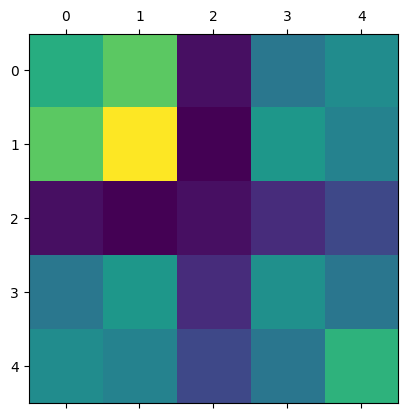

In [50]:
fig, ax = plt.subplots()
ax.matshow(X.T @ W1_opt.T @ W1_opt @ X)

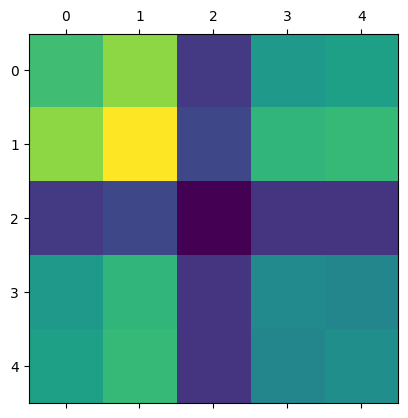

In [52]:
fig, ax = plt.subplots()
ax.matshow(X.T @ v @ s @ v.T @ X)

In [53]:
print(np.linalg.norm(W2_opt), np.linalg.norm(W1_opt))

1.0102538448518585 3.2858320195662656


In [70]:
import jax
sig_xx = 1. / n * X @ X.T
sig_yx = 1. / n * Y @ X.T

u, s, v = ds.compact_svd(sig_yx @ np.linalg.pinv(sig_xx))
r = jax.random.orthogonal(jax.random.key(1), d)[:, :s.shape[0]]
w1 = r @ np.sqrt(s) @ v.T
w2 = u @ np.sqrt(s) @ r.T

In [72]:
print(np.linalg.norm(w2), np.linalg.norm(w1))

1.4700991 1.4700993


In [65]:
u2, s2, v2 = ds.compact_svd(W2_opt)
u1, s1, v1 = ds.compact_svd(W1_opt)

In [64]:
ux, sx, vx = ds.compact_svd(X)
ux, sx, vx = ds.compact_svd(Y)

In [63]:
ut @ u

Array([[-0.41911715,  0.78354156, -0.45869765],
       [ 0.5951196 ,  0.6186277 ,  0.5129645 ],
       [ 0.68569195, -0.05798788, -0.7255783 ]], dtype=float32)

In [74]:
x = np.asarray([[1.5]])
y = np.asarray([[2.]])

u, s, v = ds.compact_svd(y @ x @ np.linalg.pinv(x @ x.T))

In [75]:
u

Array([[1.]], dtype=float32)

In [76]:
v

Array([[1.]], dtype=float32)

In [77]:
s

Array([[1.3333334]], dtype=float32)

In [80]:
2. / 1.5

1.3333333333333333

In [85]:
in_dim = 3
out_dim = 4
n = 2

x = np.random.normal(0., 1., (in_dim, n))
y = np.random.normal(0., 1., (out_dim, n))

a, b, c = ds.compact_svd(y)
d, e, f = ds.compact_svd(x)

print(y @ x.T @ np.linalg.pinv(x @ x.T))
print(a @ b @ c.T @ f @ np.linalg.pinv(e) @ d.T)

print(y @ x.T @ np.linalg.pinv(x @ x.T) @ x)
print(a @ b @ c.T @ f @ f.T)

g, h, i = ds.compact_svd(y @ x.T @ np.linalg.pinv(x @ x.T) @ x)

[[-1.09971405  0.26479683 -1.01255996]
 [-1.45398448  0.42379349 -1.18921958]
 [-3.28484898  0.85871588 -2.88700981]
 [-2.76712042  0.84636033 -2.18242443]]
[[-1.0997144   0.26479706 -1.0125602 ]
 [-1.4539849   0.4237937  -1.1892201 ]
 [-3.2848496   0.8587163  -2.8870108 ]
 [-2.767121    0.8463607  -2.182425  ]]
[[-0.65931293  0.16900919]
 [-0.72547447  0.36352381]
 [-1.83489426  0.63363611]
 [-1.30164078  0.76753137]]
[[-0.659313    0.16900934]
 [-0.7254746   0.3635239 ]
 [-1.8348945   0.63363624]
 [-1.301641    0.7675315 ]]


In [86]:
print(g)

[[-0.25243255  0.38925907]
 [-0.3038846  -0.1887708 ]
 [-0.72655004  0.5158555 ]
 [-0.5621895  -0.739416  ]]


In [87]:
print(a)

[[-0.25243255  0.38925907]
 [-0.3038846  -0.1887708 ]
 [-0.72655004  0.5158555 ]
 [-0.5621895  -0.739416  ]]


In [88]:
print(h)

[[2.665214   0.        ]
 [0.         0.26468888]]


In [89]:
print(b)

[[2.665214   0.        ]
 [0.         0.26468888]]


In [99]:
n = 5
print(np.linalg.trace(w1.T @ w1 @ (1. / n * X @ X.T)))
print(1. / n * np.linalg.trace(X.T @ w1.T @ w1 @ X))

0.89641047
0.89641047


In [98]:
1. / n * np.linalg.norm(w1 @ X)**2

np.float32(0.8964104)

In [4]:
a, b, c = ds.compact_svd(W2_opt)
d, e, f = ds.compact_svd(Y)

In [61]:
(g @ np.linalg.pinv(e) @ d.T).T @ (g @ np.linalg.pinv(e) @ d.T)

Array([[ 1.3052964 ,  0.33361754, -1.9074214 ],
       [ 0.33361754,  1.4284407 , -1.4763883 ],
       [-1.9074214 , -1.4763883 ,  4.402954  ]], dtype=float32)

In [62]:
W1_opt

array([[ 0.8340392 ,  0.53435023, -1.45002551],
       [ 1.58144566,  0.71812155, -1.52453665],
       [ 0.30937973,  0.89819108, -0.21312691]])

In [63]:
W2_opt

array([[0.00437652, 0.44311841, 0.15494625],
       [0.33741507, 0.55434539, 0.12690421],
       [0.07186918, 0.33527601, 0.47712845]])

In [ ]:
a @ b @ c.T @ g @ g.T @ 

In [5]:
a

Array([[-0.47985643, -0.0160414 , -0.87720025],
       [-0.67113394, -0.6372607 ,  0.37878507],
       [-0.56508136,  0.7704813 ,  0.29502794]], dtype=float32)

In [6]:
d

Array([[-0.4942904 ,  0.5173428 , -0.698594  ],
       [-0.6487649 , -0.75443465, -0.09966175],
       [-0.5786028 ,  0.40396142,  0.70854366]], dtype=float32)

In [8]:
Y @ X.T @ np.linalg.pinv(X @ X.T)

array([[ 0.75235511,  0.45972281, -0.71491954],
       [ 1.1973461 ,  0.69236942, -1.36142703],
       [ 0.73777638,  0.70772475, -0.71704162]])

In [9]:
Y @ np.linalg.pinv(X)

array([[ 0.75235511,  0.45972281, -0.71491954],
       [ 1.1973461 ,  0.69236942, -1.36142703],
       [ 0.73777638,  0.70772475, -0.71704162]])

In [10]:
Y @ np.linalg.pinv(X) @ X

array([[0.46071661, 0.19696137, 0.62450519, 0.18681454, 0.4378715 ],
       [0.59431701, 0.14028135, 0.97777764, 0.18007759, 0.5982239 ],
       [0.56250508, 0.20345631, 0.63988081, 0.42163185, 0.54319216]])

In [51]:
a, b, c = ds.compact_svd(Y)
d, e, g = ds.compact_svd(X)

In [52]:
k = c.T @ g @ g.T
a @ b @ k

Array([[0.4607166 , 0.19696136, 0.62450516, 0.18681468, 0.43787152],
       [0.5943169 , 0.1402814 , 0.9777775 , 0.18007761, 0.59822375],
       [0.5625049 , 0.20345621, 0.63988066, 0.42163193, 0.54319197]],      dtype=float32)

In [55]:
u, s, v = ds.compact_svd(W2_opt @ W1_opt @ X)
a @ b @ k @ v @ np.linalg.pinv(s)

Array([[-0.47985655,  0.01604646,  0.8771984 ],
       [-0.67113465,  0.6372565 , -0.3787892 ],
       [-0.5650801 , -0.7704849 , -0.295024  ]], dtype=float32)

In [77]:
a, b, c = ds.compact_svd(W2_opt)

In [57]:
a

Array([[-0.47985643, -0.0160414 , -0.87720025],
       [-0.67113394, -0.6372607 ,  0.37878507],
       [-0.56508136,  0.7704813 ,  0.29502794]], dtype=float32)

In [39]:
W2_opt @ W1_opt @ X

array([[0.46071661, 0.19696137, 0.62450519, 0.18681454, 0.4378715 ],
       [0.59431701, 0.14028135, 0.97777764, 0.18007759, 0.5982239 ],
       [0.56250508, 0.20345631, 0.63988081, 0.42163185, 0.54319216]])

In [41]:

d, e, f = ds.compact_svd(W1_opt @ X)

In [44]:
a

Array([[-0.47985643, -0.0160414 , -0.87720025],
       [-0.67113394, -0.6372607 ,  0.37878507],
       [-0.56508136,  0.7704813 ,  0.29502794]], dtype=float32)

In [46]:
a

Array([[-0.4942904 ,  0.5173428 , -0.698594  ],
       [-0.6487649 , -0.75443465, -0.09966175],
       [-0.5786028 ,  0.40396142,  0.70854366]], dtype=float32)

In [29]:
f

Array([[-0.4841164 , -0.1789474 , -0.19090322],
       [-0.15674071, -0.24301979, -0.87085676],
       [-0.6801134 ,  0.5302999 ,  0.16559263],
       [-0.23165733, -0.78394586,  0.41967297],
       [-0.47417757, -0.11458776,  0.04022928]], dtype=float32)

In [31]:
a

Array([[-0.4942904 ,  0.5173428 , -0.698594  ],
       [-0.6487649 , -0.75443465, -0.09966175],
       [-0.5786028 ,  0.40396142,  0.70854366]], dtype=float32)

In [32]:
g

Array([[-0.54937035, -0.01964059, -0.02532949],
       [-0.5616369 ,  0.34208193,  0.6399696 ],
       [-0.3466461 ,  0.32545164, -0.7383161 ],
       [-0.28253102, -0.8743741 ,  0.00277654],
       [-0.42751464, -0.11020582, -0.21137379]], dtype=float32)

In [95]:
u_

Array([[ 0.5945222 , -0.6824779 ,  0.42516735],
       [ 0.5886828 ,  0.00925694, -0.8083112 ],
       [ 0.54771864,  0.73084754,  0.40726653]], dtype=float32)

In [96]:
u

Array([[-0.5945266 ,  0.68247056,  0.42517257],
       [-0.5886829 , -0.00925449, -0.80831105],
       [-0.5477139 , -0.7308544 ,  0.40726084]], dtype=float32)

In [85]:
W2_opt @ W1_opt @ X

array([[0.84838151, 0.78194975, 0.33606017, 0.13991972, 0.71509669],
       [0.5553114 , 0.83930523, 0.63822787, 0.21013524, 0.5236236 ],
       [0.30037231, 0.92958919, 0.81623333, 0.30426915, 0.15631   ]])

In [86]:
a @ b @ c.T @ g @ g.T

Array([[0.8483817 , 0.78194994, 0.33606   , 0.1399198 , 0.7150967 ],
       [0.55531156, 0.8393056 , 0.63822794, 0.21013537, 0.52362365],
       [0.30037242, 0.9295897 , 0.8162334 , 0.30426934, 0.15630981]],      dtype=float32)

In [87]:
u

Array([[-0.5945266 ,  0.68247056,  0.42517257],
       [-0.5886829 , -0.00925449, -0.80831105],
       [-0.5477139 , -0.7308544 ,  0.40726084]], dtype=float32)

In [91]:
a @ b @ c.T @ g @ g.T @ v @ np.linalg.pinv(s)

Array([[-0.59452677,  0.68247056,  0.42517203],
       [-0.588683  , -0.00925449, -0.8083117 ],
       [-0.54771394, -0.7308539 ,  0.4072613 ]], dtype=float32)

Array([[-0.51757365, -0.65200216,  0.64977974],
       [ 0.14789581, -0.59634537,  0.67300427],
       [ 0.39818645, -0.012149  ,  0.93864435]], dtype=float32)

In [93]:
W2_opt

array([[ 0.25549737,  0.57269934, -0.38486611],
       [ 0.09681181,  0.1903763 , -0.59793615],
       [-0.37813187,  0.12189907, -0.58899921]])

In [89]:
a @ b @ c.T @ g @ g.T @ v @ np.linalg.pinv(s)

Array([[-0.51757365, -0.65200216,  0.64977974],
       [ 0.14789581, -0.59634537,  0.67300427],
       [ 0.39818645, -0.012149  ,  0.93864435]], dtype=float32)

array([[ 0.25549737,  0.57269934, -0.38486611],
       [ 0.09681181,  0.1903763 , -0.59793615],
       [-0.37813187,  0.12189907, -0.58899921]])

In [16]:
sig = 5

res = []
for i in range(1000):
    t = np.random.normal(0., sig, (12, 1))
    res.append(t.T @ t)
print(np.mean(res))

301.2949890248265


In [18]:
5**2 * 12

300

In [19]:
m = 5
n = 3

A = np.random.normal(0., sig, (m, n))

A @ A.T

array([[ 44.52906613, -48.41643501,  -1.90011994, -18.31045032,
          5.39312722],
       [-48.41643501,  54.16155872,   1.9111882 ,  24.90373269,
          1.00095311],
       [ -1.90011994,   1.9111882 ,  63.46756908, -30.40987733,
          2.61103605],
       [-18.31045032,  24.90373269, -30.40987733,  38.8149705 ,
         18.65014717],
       [  5.39312722,   1.00095311,   2.61103605,  18.65014717,
         31.8884436 ]])

In [20]:
A.T @ A

array([[ 77.62915758,   6.27854855,   8.03770888],
       [  6.27854855,  45.12327042, -12.37326749],
       [  8.03770888, -12.37326749, 110.10918003]])

In [21]:
import jax

In [33]:
def t(W, a, b):
    return jax.numpy.sum(((W @ a).T @ (W @ b))**2)

In [107]:
np.random.seed(1)
W = np.random.normal(0., 1., (3, 2))
a = np.random.normal(0., 1., (2))
b = np.random.normal(0., 1., (2))

t_0 = (W).dot(b)
t_1 = (a).dot((W.T).dot(t_0))
t_2 = (W).dot(a)

(((2 * t_1) * np.outer(t_0, a)) + ((2 * (b).dot((W.T).dot(t_2))) * np.outer(t_2, b)))

array([[ 22.1243343 , -13.27048633],
       [  1.38727979,  -0.4903022 ],
       [ 25.11639076, -14.53423688]])

In [108]:
np.random.seed(1)
W = np.random.normal(0., 1., (3, 2))
a = np.random.normal(0., 1., (2, 1))
b = np.random.normal(0., 1., (2, 1))

(((2 *  a.T @ W.T @ W @ b) * W @ b @ a.T) + ((2 * b.T @ W.T @ W @ a) * W @ a @ b.T))

array([[ 22.1243343 , -13.27048633],
       [  1.38727979,  -0.4903022 ],
       [ 25.11639076, -14.53423688]])

In [113]:
2 * a.T @ W.T @ W @ b * (W @ (b @ a.T + a @ b.T))

array([[ 22.1243343 , -13.27048633],
       [  1.38727979,  -0.4903022 ],
       [ 25.11639076, -14.53423688]])

In [111]:
b.T @ W.T @ W @ a

array([[4.97584783]])

In [114]:
2 * a.T @ W.T @ W @ b

array([[9.95169567]])

In [137]:
m = 4
n = 3
sigma = 1.5

samples = 100000
res = []

e1 = np.random.normal(0., sigma, (m, n, samples))
for i in range(samples):
    res.append(e1[:, :, i].T @ e1[:, :, i])
print(np.round(np.mean(res, axis=0), 2))
print(m * sigma**2 * np.identity(n))

[[ 8.99  0.   -0.02]
 [ 0.    9.03 -0.01]
 [-0.02 -0.01  8.98]]
[[9. 0. 0.]
 [0. 9. 0.]
 [0. 0. 9.]]


In [139]:
m = 4
n = 3
sigma = 1.5

samples = 100000
res = []

e1 = np.random.normal(0., sigma, (m, n, samples))
for i in range(samples):
    res.append(e1[:, :, i] @ e1[:, :, i].T)
print(np.round(np.mean(res, axis=0), 2))
print(n * sigma**2 * np.identity(m))

[[ 6.74  0.01 -0.02 -0.02]
 [ 0.01  6.73  0.    0.02]
 [-0.02  0.    6.78 -0.  ]
 [-0.02  0.02 -0.    6.74]]
[[6.75 0.   0.   0.  ]
 [0.   6.75 0.   0.  ]
 [0.   0.   6.75 0.  ]
 [0.   0.   0.   6.75]]


In [145]:
m = 4
n = 3
sigma = 1.5

samples = 2000000
res = []

b = np.random.normal(2., 2., (m, m))
e1 = np.random.normal(0., sigma, (m, n, samples))
for i in range(samples):
    res.append(e1[:, :, i].T @ b @ e1[:, :, i])
print(np.round(np.mean(res, axis=0), 2))
print(sigma**2 * np.trace(b) * np.identity(n))

[[13.96  0.    0.  ]
 [-0.03 14.   -0.03]
 [-0.   -0.03 13.97]]
[[13.96874871  0.          0.        ]
 [ 0.         13.96874871  0.        ]
 [ 0.          0.         13.96874871]]


In [152]:
m = 4
n = 3
sigma1 = 1.5
sigma2 = 2.

samples = 200000
res = []

b = np.random.normal(0.5, 2., (m, m))
e1 = np.random.normal(0., sigma1, (m, n, samples))
xi = np.random.normal(0., sigma2, (n, 1, samples))
for i in range(samples):
    res.append(xi[:, :, i].T @ e1[:, :, i].T @ b.T @ b @ e1[:, :, i] @ xi[:, :, i])
print(np.round(np.mean(res, axis=0), 2))

[[2307.38]]


In [169]:
np.random.seed(1)

N_i = 3
N_h = 4
N_o = 5

w1 = np.random.normal(0., 1., (N_h, N_i))
w2 = np.random.normal(0., 1., (N_o, N_h))

s1 = 0.5
s2 = 1.5
sx = 0.75

samples = 200000
xis = np.random.normal(0., sx, (samples, N_i, 1))
e1s = np.random.normal(0., s1, (samples, N_h, N_i))
e2s = np.random.normal(0., s2, (samples, N_o, N_h))


res = []
for i in range(samples):
    res.append(xis[i].T @ e1s[i].T @ e2s[i].T @ e2s[i] @ e1s[i] @ xis[i])
print(np.round(np.mean(res, axis=0), 2))
print(s1**2 * s2**2 * sx**2 * N_i * N_h * N_o)


""" Summand 6
res = []
for i in range(samples):
    res.append(xis[i].T @ w1.T @ e2s[i].T @ e2s[i] @ w1 @ xis[i])
print(np.round(np.mean(res, axis=0), 2))
print(sx**2 * s2**2 * N_o * np.linalg.norm(w1, ord="fro")**2)
"""


[[18.97]]
18.984375


' Summand 6\nres = []\nfor i in range(samples):\n    res.append(xis[i].T @ w1.T @ e2s[i].T @ e2s[i] @ w1 @ xis[i])\nprint(np.round(np.mean(res, axis=0), 2))\nprint(sx**2 * s2**2 * N_o * np.linalg.norm(w1, ord="fro")**2)\n'

In [168]:
print(sx**2 * s2**2 * N_o * np.linalg.norm(w1, ord="fro")**2)

130.73081380326542


In [179]:
np.random.seed(1)

w1 = np.random.normal(0., 1., (4, 3))
X = np.random.normal(0., 1., (3, 2))
Y = np.random.normal(0., 1., (7, 2))
sig_xx = X @ X.T
sig_yx = Y @ X.T

a, b, c = ds.compact_svd(w1 @ sig_xx)

P = w1 @ sig_xx @ np.linalg.pinv((w1 @ sig_xx).T @ (w1 @ sig_xx)) @ (w1 @ sig_xx).T
print(P)

print(a @ a.T)

print(w1 @ sig_xx @ np.linalg.pinv(w1 @ sig_xx))



[[ 0.46352089  0.27051053  0.26893577 -0.32119601]
 [ 0.27051053  0.85979649 -0.0868737   0.19955825]
 [ 0.26893577 -0.0868737   0.24073307 -0.32079147]
 [-0.32119601  0.19955825 -0.32079147  0.43594955]]
[[ 0.46352088  0.2705104   0.2689358  -0.3211961 ]
 [ 0.2705104   0.8597966  -0.08687381  0.1995584 ]
 [ 0.2689358  -0.08687381  0.24073313 -0.32079157]
 [-0.3211961   0.1995584  -0.32079157  0.43594977]]
[[ 0.46352089  0.27051053  0.26893577 -0.32119601]
 [ 0.27051053  0.85979649 -0.0868737   0.19955825]
 [ 0.26893577 -0.0868737   0.24073307 -0.32079147]
 [-0.32119601  0.19955825 -0.32079147  0.43594955]]


In [207]:
w2 = np.random.normal(0., 1., (3, 5))

print(np.linalg.pinv(w2) @ w2)

[[ 0.61546478  0.3046623  -0.01609229  0.23374617 -0.29824911]
 [ 0.3046623   0.74243473  0.05017241 -0.08203426  0.29859571]
 [-0.01609229  0.05017241  0.91279977 -0.22873872 -0.15652065]
 [ 0.23374617 -0.08203426 -0.22873872  0.20040473 -0.21576464]
 [-0.29824911  0.29859571 -0.15652065 -0.21576464  0.52889599]]


In [209]:
np.random.seed(1)

X = np.random.normal(0., 1., (3, 4))
Y = np.random.normal(0., 1., (2, 2))


a, b, c = ds.compact_svd(Y)
d, e, f = ds.compact_svd(X)

print((d.T @ d) @ (d.T @ d).T)
print((d.T @ d).T @ (d.T @ d))

[[ 1.0000005e+00 -1.5276694e-07 -2.9652830e-08]
 [-1.5276694e-07  9.9999976e-01  9.8990945e-08]
 [-2.9652830e-08  9.8990945e-08  9.9999976e-01]]
[[ 1.0000005e+00 -1.5276694e-07 -2.9652830e-08]
 [-1.5276694e-07  9.9999976e-01  9.8990945e-08]
 [-2.9652830e-08  9.8990945e-08  9.9999976e-01]]


In [198]:
(f.T @ f) @ (f.T @ f).T

Array([[1.0000002e+00, 5.7769869e-09],
       [5.7769869e-09, 1.0000002e+00]], dtype=float32)

In [186]:
d @ d.T

Array([[9.9999982e-01, 3.9980954e-08, 6.4134404e-08],
       [3.9980954e-08, 1.0000001e+00, 1.4573563e-07],
       [6.4134404e-08, 1.4573563e-07, 1.0000000e+00]], dtype=float32)

In [180]:
print(a @ a.T @ sig_yx - sig_yx)

TypeError: dot_general requires contracting dimensions to have the same shape, got (4,) and (7,).

In [214]:
np.random.seed(1)

p = np.random.normal(0., 1., (3, 3))

p @ np.linalg.pinv(p)

array([[ 1.00000000e+00,  1.82378615e-15,  4.03468009e-15],
       [ 6.27470430e-15,  1.00000000e+00, -4.47297675e-15],
       [-3.77308072e-15,  3.19989249e-16,  1.00000000e+00]])

In [212]:
np.random.normal(0., 1., (2, 4))

array([[-0.6871727 , -0.84520564, -0.67124613, -0.0126646 ],
       [-1.11731035,  0.2344157 ,  1.65980218,  0.74204416]])

In [157]:
print(sigma1**2 *sigma2**2 * n * np.linalg.norm(b, ord="fro")**2)

2308.9962222930335


In [129]:
3 * 1.5

4.5

In [131]:
e1[:, :, 0]

array([[ 0.03444965,  1.18183998,  2.28229517],
       [-3.43505503, -0.42002832,  2.54424575]])

In [67]:
jax.grad(t)(W, a, b)

Array([[75.79375  , 64.548256 ],
       [ 5.4631524,  7.157553 ],
       [66.41329  , 67.92595  ]], dtype=float32)

In [64]:
print(jax.make_jaxpr(jax.grad(t))(W, a, b))

{ lambda ; a:f32[3,2] b:f32[2,1] c:f32[2,1]. let
    d:f32[3,1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a b
    e:f32[1,3] = transpose[permutation=(1, 0)] d
    f:f32[3,1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] a c
    g:f32[1,1] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] e f
    h:f32[1,1] = integer_pow[y=2] g
    i:f32[1,1] = integer_pow[y=1] g
    j:f32[1,1] = mul 2.0 i
    _:f32[] = reduce_sum[axes=(0, 1)] h
    k:f32[1,1] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(1, 1)
      sharding=None
    ] 1.0
    l:f32[1,1] = mul k j
    m:f32[1,3] = dot_general[
      dimension_numbers=(([0], [0]), ([], []))
      preferred_element_type=float32
    ] l e
    n:f32[3,1] = transpose[permutation=(1, 0)] m
    o:f32[1,3] = dot_general[
      dimension_numbers=(([1], [1]), ([], []))
  

In [63]:
((W @ a) @ (W @ b).T)**2

array([[6.85144039e-05, 4.92051429e-05, 2.50527150e-02],
       [1.59510218e-03, 1.14555810e-03, 5.83258962e-01],
       [7.59874925e-03, 5.45721077e-03, 2.77852960e+00]])

In [52]:
f

<function __main__.t(W, a, b)>

In [37]:
2 * a.T @ W.T @ W @ b @ W @ b @ a.T

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 1)

In [36]:
2* (W @ (a @ b.T) + W @ b @ a.T)

array([[ -8.02215275,   3.5124232 ],
       [-15.15898029,   8.05699358],
       [  9.45769162,  -5.496539  ]])

In [29]:
((W @ a).T @ (W @ b))**2

array([[0.36462976]])

In [48]:
(W).dot(b)

array([-1.08622792, -0.262251  , -0.72812353])

In [47]:
from __future__ import division, print_function, absolute_import

import numpy as np

def fAndG(W, a, b):
    assert isinstance(W, np.ndarray)
    dim = W.shape
    assert len(dim) == 2
    W_rows = dim[0]
    W_cols = dim[1]
    assert isinstance(a, np.ndarray)
    dim = a.shape
    assert len(dim) == 1
    a_rows = dim[0]
    assert isinstance(b, np.ndarray)
    dim = b.shape
    assert len(dim) == 1
    b_rows = dim[0]
    assert W_cols == b_rows == a_rows

    t_0 = (W).dot(b)
    t_1 = (a).dot((W.T).dot(t_0))
    t_2 = (W).dot(a)
    functionValue = (t_1 ** 2)
    gradient = (((2 * t_1) * np.outer(t_0, a)) + ((2 * (b).dot((W.T).dot(t_2))) * np.outer(t_2, b)))

    return functionValue, gradient

def checkGradient(W, a, b):
    # numerical gradient checking
    # f(x + t * delta) - f(x - t * delta) / (2t)
    # should be roughly equal to inner product <g, delta>
    t = 1E-6
    delta = np.random.randn(3, 3)
    f1, _ = fAndG(W + t * delta, a, b)
    f2, _ = fAndG(W - t * delta, a, b)
    f, g = fAndG(W, a, b)
    print('approximation error',
          np.linalg.norm((f1 - f2) / (2*t) - np.tensordot(g, delta, axes=2)))

def generateRandomData():
    W = np.random.randn(3, 3)
    a = np.random.randn(3)
    b = np.random.randn(3)

    return W, a, b

functionValue, gradient = fAndG(W, a, b)
print('functionValue = ', functionValue)
print('gradient = ', gradient)

print('numerical gradient checking ...')
checkGradient(W, a, b)

functionValue =  17.56022897318999
gradient =  [[-33.57601237  -4.10375864]
 [ -8.19453625  -1.00092959]
 [-22.49168671  -2.74910775]]
numerical gradient checking ...


ValueError: operands could not be broadcast together with shapes (3,2) (3,3) 